In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import lasso_path
import warnings

In [78]:
# Setup and Configuration
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
final_results = {}

# Data Generation
def generate_data(n_samples=150, n_features=25, noise_std=1.0, random_state=42):
    """Generates a synthetic dataset with specific characteristics."""
    np.random.seed(random_state)
    X = np.random.randn(n_samples, n_features)
    y = (2 * X[:, 0] + np.sin(2 * np.pi * X[:, 1]) + 0.5 * X[:, 2]**2 - 1.5 * X[:, 3] + 
         np.random.normal(0, noise_std, n_samples))
    X[:, 4] = 0.8 * X[:, 0] + 0.2 * np.random.randn(n_samples) # Multicollinearity
    return X, y

# Generate, split, and scale the data immediately
X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data generated and prepared.")

Data generated and prepared.


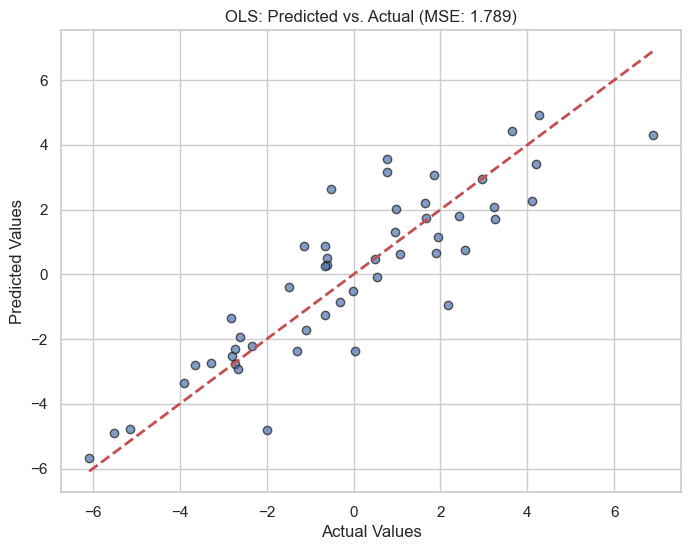

In [79]:
# Model 1: Ordinary Least Squares (OLS)
def run_ols_and_plot(X_train, y_train, X_test, y_test):
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    final_results['OLS'] = mse
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f"OLS: Predicted vs. Actual (MSE: {mse:.3f})")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.savefig( "Final_OLS.png")
    plt.show()

run_ols_and_plot(X_train_scaled, y_train, X_test_scaled, y_test)

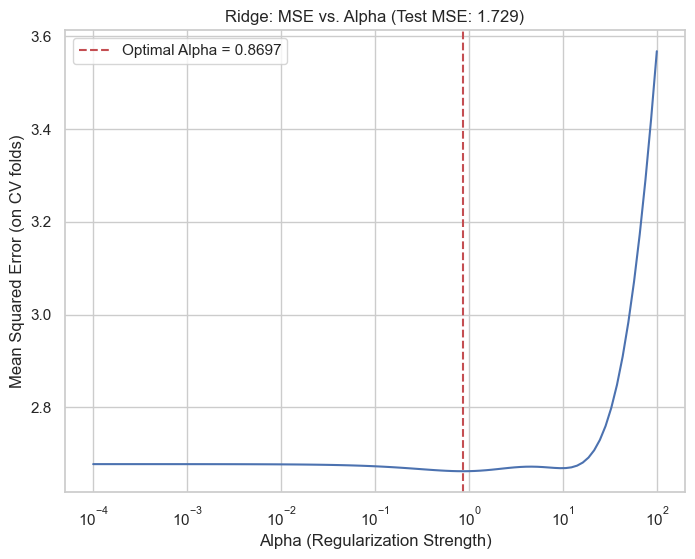

In [80]:
# Model 2: Ridge Regression
def run_ridge_and_plot(X_train, y_train, X_test, y_test):
    alphas = np.logspace(-4, 2, 100)
    model_cv = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_train, y_train)
    best_alpha = model_cv.alpha_
    y_pred = model_cv.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    final_results['Ridge'] = mse
    
    plt.figure(figsize=(8, 6))
    mse_path = np.mean(model_cv.cv_values_, axis=0)
    plt.plot(alphas, mse_path)
    plt.xscale('log')
    plt.axvline(best_alpha, linestyle='--', color='r', label=f'Optimal Alpha = {best_alpha:.4f}')
    plt.title(f"Ridge: MSE vs. Alpha (Test MSE: {mse:.3f})")
    plt.xlabel("Alpha (Regularization Strength)")
    plt.ylabel("Mean Squared Error (on CV folds)")
    plt.legend()
    plt.savefig( "Final_Ridge_Regression.png")
    plt.show()

run_ridge_and_plot(X_train_scaled, y_train, X_test_scaled, y_test)

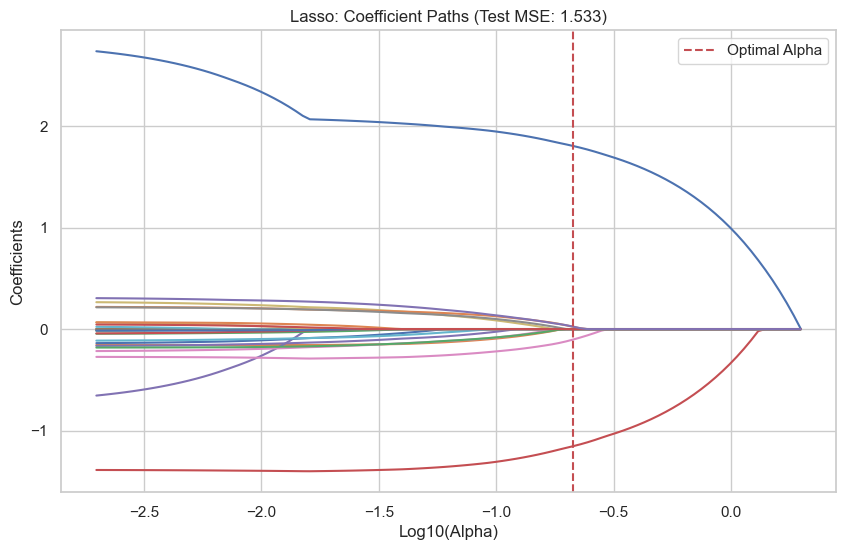

In [81]:
# Model 3: Lasso Regression
def run_lasso_and_plot(X_train, y_train, X_test, y_test):
    # We still use LassoCV to find the best alpha efficiently
    model_cv = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)
    best_alpha = model_cv.alpha_
    y_pred = model_cv.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    final_results['Lasso'] = mse

    plt.figure(figsize=(10, 6))
    
    # To get the paths for plotting, we call the dedicated lasso_path function.
    # We use the alphas that LassoCV found to be relevant.
    alphas_for_path, coefs_for_path, _ = lasso_path(X_train, y_train, alphas=model_cv.alphas_, max_iter=10000)
    
    plt.plot(np.log10(alphas_for_path), coefs_for_path.T)
    plt.axvline(np.log10(best_alpha), linestyle='--', color='r', label=f'Optimal Alpha')
    plt.title(f"Lasso: Coefficient Paths (Test MSE: {mse:.3f})")
    plt.xlabel("Log10(Alpha)")
    plt.ylabel("Coefficients")
    plt.legend()
    plt.savefig("Final_LASSO.png")
    plt.show()

run_lasso_and_plot(X_train_scaled, y_train, X_test_scaled, y_test)

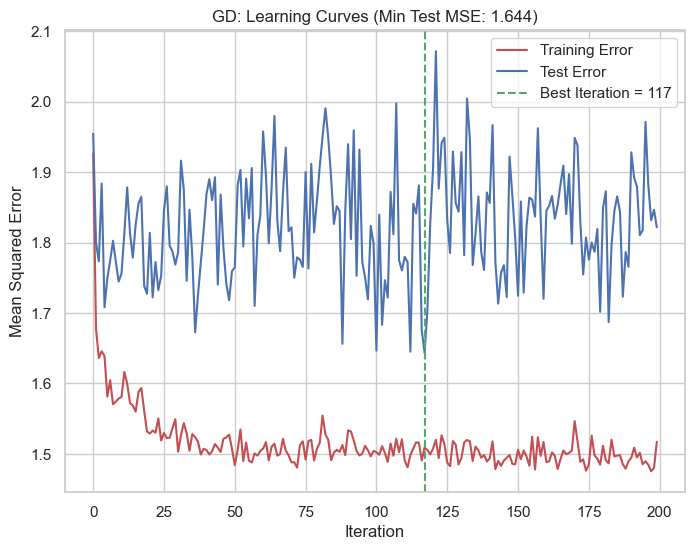

In [82]:
# Model 4: Gradient Descent
def run_gd_and_plot(X_train, y_train, X_test, y_test):
    model = SGDRegressor(max_iter=1, tol=None, warm_start=True, penalty=None, learning_rate='constant', eta0=0.01)
    train_errors, test_errors = [], []
    for _ in range(200):
        model.fit(X_train, y_train)
        train_errors.append(mean_squared_error(y_train, model.predict(X_train)))
        test_errors.append(mean_squared_error(y_test, model.predict(X_test)))
    
    best_iter = np.argmin(test_errors)
    min_test_error = test_errors[best_iter]
    final_results['GD Early Stop'] = min_test_error

    plt.figure(figsize=(8, 6))
    plt.plot(train_errors, "r-", label="Training Error")
    plt.plot(test_errors, "b-", label="Test Error")
    plt.axvline(best_iter, linestyle='--', color='g', label=f'Best Iteration = {best_iter}')
    plt.title(f"GD: Learning Curves (Min Test MSE: {min_test_error:.3f})")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.savefig("Final_GD.png")
    plt.show()

run_gd_and_plot(X_train_scaled, y_train, X_test_scaled, y_test)

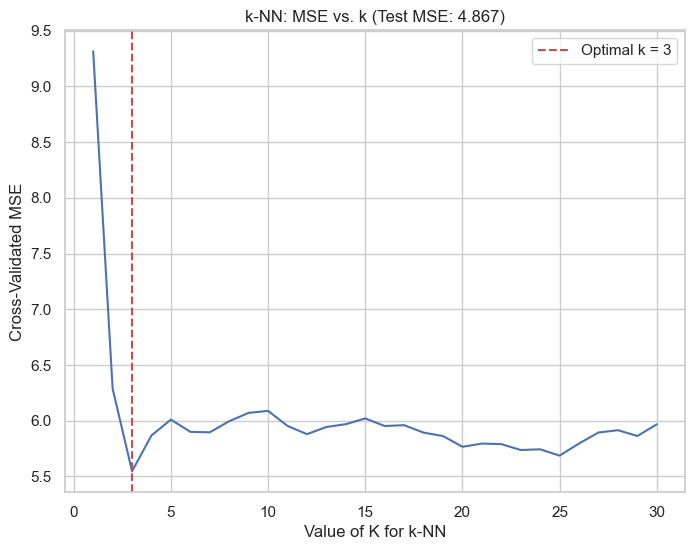

In [83]:
# Model 5: k-Nearest Neighbors
def run_knn_and_plot(X_train, y_train, X_test, y_test):
    k_range = range(1, 31)
    k_scores = [-cross_val_score(KNeighborsRegressor(k), X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean() for k in k_range]
    best_k = k_range[np.argmin(k_scores)]
    
    model = KNeighborsRegressor(n_neighbors=best_k).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    final_results['k-NN'] = mse
    
    plt.figure(figsize=(8, 6))
    plt.plot(k_range, k_scores)
    plt.axvline(best_k, linestyle='--', color='r', label=f'Optimal k = {best_k}')
    plt.title(f"k-NN: MSE vs. k (Test MSE: {mse:.3f})")
    plt.xlabel("Value of K for k-NN")
    plt.ylabel("Cross-Validated MSE")
    plt.legend()
    plt.savefig("Final_k_NN.png")
    plt.show()

run_knn_and_plot(X_train_scaled, y_train, X_test_scaled, y_test)

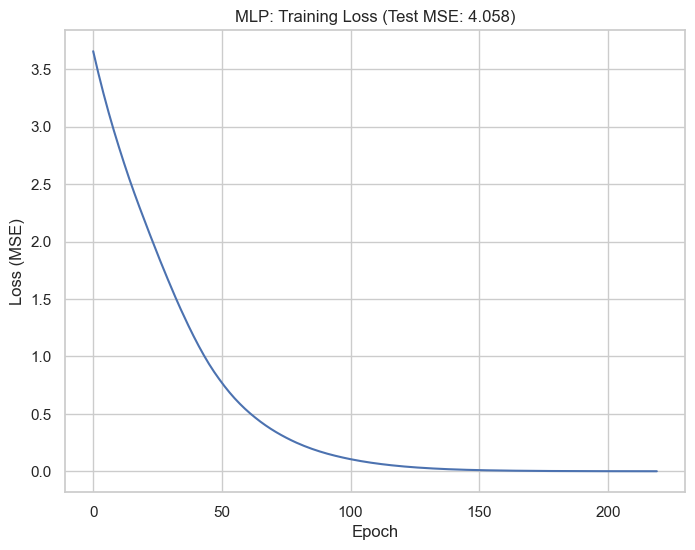

In [84]:
# Model 6: Multi-layer Perceptron (MLP)
def run_mlp_and_plot(X_train, y_train, X_test, y_test):
    model = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, early_stopping=True, random_state=0, n_iter_no_change=15).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    final_results['MLP'] = mse
    
    plt.figure(figsize=(8, 6))
    plt.plot(model.loss_curve_)
    plt.title(f"MLP: Training Loss (Test MSE: {mse:.3f})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.savefig("Final_MLP.png")
    plt.show()

run_mlp_and_plot(X_train_scaled, y_train, X_test_scaled, y_test)

In [92]:
# Final Summary
print("Final Results Summary \n")
summary_df = pd.DataFrame.from_dict(final_results, orient='index', columns=['Test MSE'])
print(summary_df.sort_values('Test MSE'))


Final Results Summary 

               Test MSE
Lasso          1.532523
GD Early Stop  1.643584
Ridge          1.729337
OLS            1.788932
MLP            4.057625
k-NN           4.867078
